# Regressão Linear Múltipla

Nesta aula, exploraremos o modelo de regressão linear múltipla, que incorpora múltiplos preditores (variáveis independentes) para estimar uma variável dependente. O objetivo é aprender os parâmetros $\beta_i$ e $\alpha$ de tal forma que $f(\mathbf{x}) = \beta_i \cdot \mathbf{x} + \alpha + \varepsilon$, onde $\varepsilon$ representa o erro do modelo. Na abordagem Bayesiana, é necessário definir distribuições a priori para cada um dos $\beta_i$, para $\alpha$, e também para $\varepsilon$.

# Exemplo

Como estudo de caso, utilizaremos o conjunto de dados disponível no Colab referente ao mercado imobiliário da Califórnia nos anos 90. Este dataset nos permite aplicar a regressão linear múltipla para analisar como diferentes características das habitações (como localização, tamanho e número de quartos) afetam seus preços.

In [1]:
import pandas as pd

df = pd.read_csv("sample_data/california_housing_train.csv")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0
16996,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0
16997,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0
16998,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0


Neste modelo, consideramos diversas variáveis explicativas para prever o preço das habitações. As variáveis incluem a mediana dos salários, representada por $\beta_{\text{income}}$, e a mediana da idade dos imóveis, representada por $\beta_{\text{age}}$. Além disso, o modelo incorpora um termo de intercepto $\alpha$ e um termo de erro $\varepsilon$. Adotamos distribuições normais como prioris para todas as variáveis. A escolha inicial dos parâmetros de média e dispersão influenciam a rapidez com que o algoritmo MCMC (Markov Chain Monte Carlo) convergirá.

Diferentemente das outras variáveis, o erro $\varepsilon$ é modelado utilizando uma distribuição Half-Normal. Essa escolha é intencional, pois essa distribuição permite apenas valores positivos e tem média zero, adequando-se à natureza dos erros que esperamos no contexto deste modelo. A utilização da distribuição Half-Normal para o erro sublinha a expectativa de que os desvios em relação às previsões do modelo sejam não-negativos, reforçando a coerência do modelo com as propriedades estatísticas dos dados.

In [7]:
import pymc as pm

median_income = df['median_income'].values
housing_median_age = df['housing_median_age'].values
median_house_value = df['median_house_value'].values

In [2]:
with pm.Model() as multi_linreg:

    alpha = pm.Normal('alpha', 0, 100000)
    beta_income = pm.Normal('beta_income', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    epsilon = pm.HalfNormal('epsilon', 100)

    mu = alpha + beta_income * median_income + beta_age * housing_median_age

    Y_obs = pm.Normal('Y_obs', mu, epsilon, observed=median_house_value)

# Análise Preditiva a Priori

A função `sample_prior_predictive` é utilizada para executar a análise preditiva a priori dos parâmetros do modelo, incluindo as inclinações, o intercepto e o erro. Esta análise permite simular dados preditos pelo modelo antes de ajustá-lo aos dados observados, usando apenas as informações fornecidas pelas distribuições a priori dos parâmetros.

A fórmula geral para da distribuição para a análise preditiva a priori pode ser descrita como:

$ p(y) = \int\limits_{\theta} p(y | \theta)p(\theta) d\theta $

Em nosso modelo, isso se reduz a uma tranquila integral QUADRÚPLA:

$p(y) = \int\limits_{\beta_{income}} \int\limits_{\beta_{age}} \int\limits_{\alpha} \int\limits_ɛ p(y_{\text{pred}} | \beta_{\text{income}}, \beta_{\text{age}}, \alpha, \varepsilon) \cdot p(\beta_{\text{income}}) \cdot p(\beta_{\text{age}}) \cdot p(\alpha) \cdot p(\varepsilon) \, d\beta_{\text{income}} \, d\beta_{\text{age}} \, d\alpha \, d\varepsilon$

Essa análise é importante por várias razões:
- **Validação do Modelo:** Permite verificar se o modelo é capaz de gerar dados que se assemelham à realidade, com base nas distribuições a priori escolhidas para os parâmetros.
- **Verificação de Suposições:** Ajuda a identificar se as suposições feitas sobre as distribuições a priori são razoáveis, observando os dados simulados.
- **Ajuste de Parâmetros:** Oferece uma oportunidade para ajustar as distribuições a priori antes do processo de estimativa, otimizando a convergência do modelo e a precisão das previsões.
- **Entendimento Intuitivo:** Facilita a compreensão do impacto potencial de cada variável independente sobre a variável dependente, antes mesmo da análise dos dados reais.

Essa etapa preliminar é crucial para garantir que o modelo proposto está bem fundamentado e tem o potencial de oferecer insights valiosos a partir dos dados reais.


In [3]:
with multi_linreg:
  prior_trace = pm.sample_prior_predictive()

In [18]:
prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<Axes: ylabel='Count'>

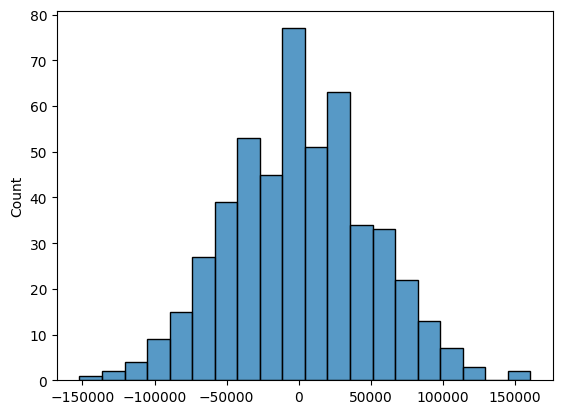

In [4]:
import seaborn as sns

sns.histplot(prior_trace.prior['beta_income'].values.flatten(), bins=20)

<Axes: ylabel='Count'>

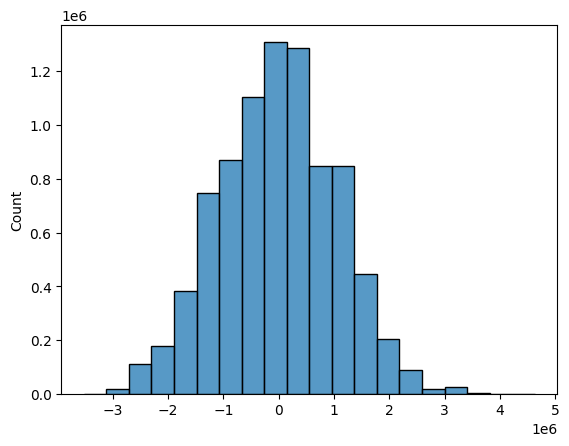

In [5]:
sns.histplot(prior_trace.prior_predictive['Y_obs'].values.flatten(), bins=20)

In [2]:
import arviz as az
import matplotlib.pyplot as plt


A função plot_ppc do ArviZ é utilizada para visualizar os valores preditivos gerados pela análise a priori ou a posteriori, comparando-os com os dados observados. Além disso, essa função desenha uma linha representando a média dos valores preditivos, oferecendo uma visão clara da tendência central das previsões em relação aos dados reais.

No gráfico apresentado abaixo, observamos desafios significativos relacionados à escala dos valores preditivos em comparação com os dados observados. Isso sugere a necessidade de ajustes nos parâmetros das distribuições priori utilizadas no modelo. A presença de discrepâncias de escala entre as previsões e os valores reais indica que as distribuições a priori podem não estar adequadamente calibradas, levando a previsões que não capturam a variação ou a magnitude dos dados observados de maneira eficaz.

Ajustar esses parâmetros é crucial para melhorar a precisão e a relevância das previsões geradas pelo modelo.

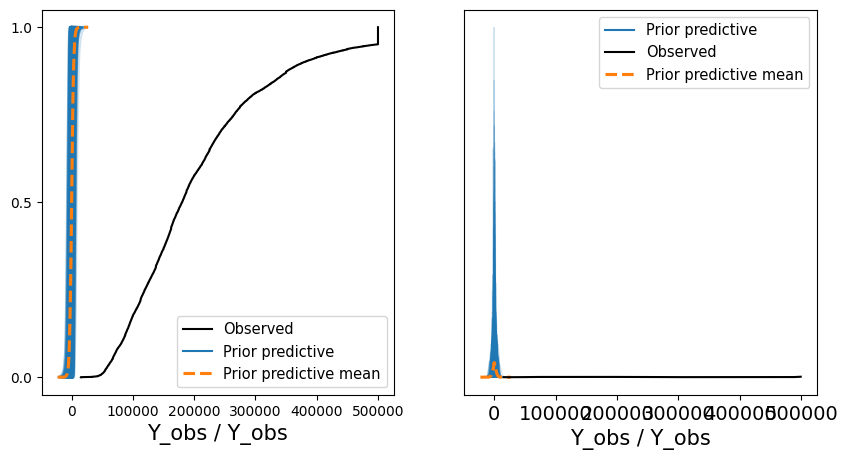

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(prior_trace, group='prior', kind='cumulative',ax=axes[0]);
az.plot_ppc(prior_trace, group='prior',ax=axes[1]);

Nesta fase do processo, procedemos à estimação dos parâmetros do modelo utilizando a função sample(), como discutido anteriormente. Esse método é fundamental no contexto da inferência Bayesiana, pois permite a amostragem a partir da distribuição posterior dos parâmetros, com base nos dados observados e nas distribuições a priori definidas. A função sample() emprega algoritmos de amostragem, como o Markov Chain Monte Carlo (MCMC), para gerar uma série de amostras que representam as estimativas dos parâmetros do modelo.

In [6]:
with multi_linreg:
  trace = pm.sample()

pm.summary(trace)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-11105.791,831.924,-12533.762,-9426.680,28.490,20.303,853.0,869.0,1.00
beta_income,43386.438,128.788,43152.612,43631.557,4.139,2.928,973.0,1214.0,1.00
beta_age,1746.105,19.409,1709.967,1780.236,0.590,0.418,1075.0,1053.0,1.00
epsilon,31187.596,48.442,31105.782,31280.612,1.252,0.885,1482.0,1307.0,1.01


# Análise Preditiva a Posteriori

De fato, o passo mais importante da disciplina de Análise Preditiva.

A função `sample_posterior_predictive` é utilizada para executar a análise preditiva a posteriori dos parâmetros do modelo, após a estimação dos mesmos. Essa etapa envolve a geração de dados preditos com base nos parâmetros aprendidos durante a inferência, permitindo assim avaliar como o modelo ajustado se comporta em relação aos dados observados e não observados.

A distribuição para a análise preditiva a posteriori pode ser conceitualmente expressa como:

$ p(y_{\text{new}} | y_{\text{obs}}) = \int\limits_{\theta} p(y_{\text{new}} | \theta)p(\theta | y_{\text{obs}}) d\theta $

Onde $y_{\text{new}}$ representa novos dados preditos e $y_{\text{obs}}$ são os dados observados. O termo $p(\theta | y_{\text{obs}})$ é a distribuição posterior dos parâmetros do modelo, e $p(y_{\text{new}} | \theta)$ é a probabilidade dos novos dados preditos dado os parâmetros $\theta$.

A análise preditiva a posteriori é fundamental por várias razões:
- **Validação e Comparação do Modelo:** Facilita a validação do modelo ajustado ao comparar previsões com os dados observados, ajudando a avaliar a adequação do modelo.
- **Incerteza nas Previsões:** Permite quantificar a incerteza nas previsões, oferecendo uma gama de possíveis resultados baseados na distribuição posterior dos parâmetros.
- **Decisões Informadas:** Auxilia na tomada de decisões baseadas em evidências, utilizando as previsões e a incerteza associada para informar ações futuras.
- **Interpretação Realista:** Fornece uma interpretação realista do que o modelo pode prever, levando em conta o conhecimento adquirido dos dados.

Essa análise constitui uma etapa crítica após a inferência, assegurando que o modelo não apenas se ajusta bem aos dados existentes, mas também é capaz de fazer previsões úteis e informadas para novos conjuntos de dados, validando assim sua aplicabilidade e robustez.


In [23]:
with multi_linreg:
    trace_post = pm.sample_posterior_predictive(trace)

array([<Axes: xlabel='Y_obs / Y_obs'>], dtype=object)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


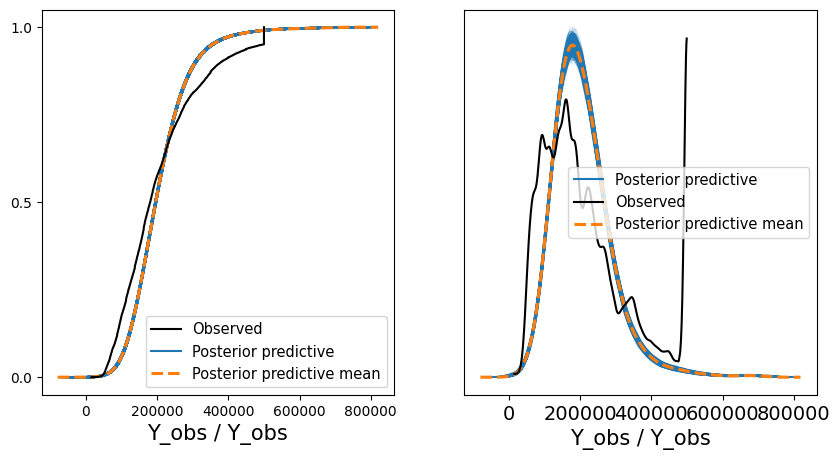

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_post, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(trace_post, group='posterior', ax=axes[1])

Com base na imagem apresentada, nota-se que os dados exercem um impacto significativo nos parâmetros, resultando em previsões que se distanciam das expectativas estabelecidas pela análise a priori. Esta influência é evidente na alteração das distribuições preditivas a posteriori. A qualidade do ajuste do modelo avançou de forma considerável, embora ainda não atinja um patamar ótimo.

In [3]:
population = df['population'].values

In [9]:
with pm.Model() as multi_linreg_pop:

    alpha = pm.Normal('alpha', 0, 100000)
    beta_income = pm.Normal('beta_income', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    beta_pop = pm.Normal('beta_pop', 0, 5)
    sigma = pm.HalfNormal('sigma', 1000)

    mu = alpha + beta_income * median_income + beta_age * housing_median_age + beta_pop * population

    Y_obs = pm.Normal('Y_obs', mu, sigma, observed=median_house_value)

In [10]:
with multi_linreg_pop:
  trace_pop = pm.sample()

pm.summary(trace_pop)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-18284.898,2200.481,-22322.756,-14256.877,69.228,49.434,1023.0,1071.0,1.00
beta_income,43452.477,280.719,42922.544,43970.895,6.985,4.942,1622.0,1413.0,1.00
beta_age,1830.574,47.916,1736.030,1916.907,1.322,0.938,1313.0,1081.0,1.00
beta_pop,3.148,0.503,2.293,4.151,0.013,0.010,1458.0,1127.0,1.01
sigma,70955.413,314.836,70360.948,71523.097,7.096,5.019,1980.0,1040.0,1.00


In [11]:
with multi_linreg_pop:
    trace_post_pop = pm.sample_posterior_predictive(trace_pop)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: xlabel='Y_obs / Y_obs'>], dtype=object)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


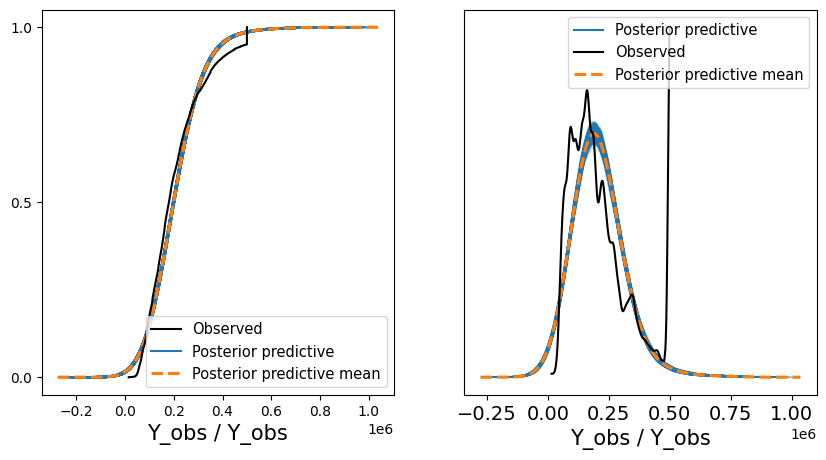

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_post_pop, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(trace_post_pop, group='posterior', ax=axes[1])

Na imagem fornecida, é notável que a distribuição preditiva posterior reflete efetivamente o padrão dos dados observados, em especial a característica do pico mais pronunciado. Isso indica que a inclusão da variável 'população' como um preditor no modelo é benéfica para capturar a tendência central e a dispersão dos dados. A capacidade do modelo de replicar tal pico é uma evidência de sua adequação em relação a este aspecto específico dos dados.

Este alinhamento entre as previsões e os dados observados sugere que o modelo tem um bom ajuste, pelo menos no que se refere à característica da população. Contudo, sempre há espaço para aprimoramento. Poderíamos, por exemplo, investigar a possibilidade de refinamento das distribuições a priori, a inclusão de interações entre variáveis ou mesmo a exploração de modelos hierárquicos ou não lineares, a fim de melhorar a abrangência e a precisão das previsões para todos os aspectos dos dados observados.

In [8]:
with pm.Model() as multi_linreg_pop_t:

    alpha = pm.Normal('alpha', 0, 100000)
    beta_income = pm.Normal('beta_income', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    beta_pop = pm.Normal('beta_pop', 0, 5)
    sigma = pm.HalfNormal('sigma', 10000)

    mu = alpha + beta_income * median_income + beta_age * housing_median_age + beta_pop * population
    df = pm.Exponential("df",1)
    Y_obs = pm.StudentT('Y_obs', nu=df, mu=mu, sigma=sigma, observed=median_house_value)

In [9]:
with multi_linreg_pop_t:
  trace_p = pm.sample()

pm.summary(trace_p)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-35511.205,2133.412,-39449.827,-31254.594,65.444,46.289,1069.0,1101.0,1.0
beta_income,45630.968,299.163,45052.917,46167.820,7.968,5.636,1411.0,1239.0,1.0
beta_age,1664.064,45.051,1580.697,1750.975,1.193,0.844,1425.0,1481.0,1.0
beta_pop,4.079,0.486,3.164,4.959,0.012,0.009,1517.0,1234.0,1.0
sigma,57057.325,577.785,55933.482,58076.352,15.077,10.670,1469.0,1298.0,1.0
df,3.635,0.114,3.437,3.857,0.003,0.002,1437.0,1341.0,1.0


In [10]:
with multi_linreg_pop_t:
    trace_post_t = pm.sample_posterior_predictive(trace_p)

O modelo robusto que inclui a variável de população apresenta um grau de liberdade (df) reduzido, o que indica uma sensibilidade considerável do modelo aos outliers. Este baixo grau de liberdade sugere que as anomalias nos dados têm um impacto substancial na estimativa dos parâmetros do modelo.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: xlabel='Y_obs / Y_obs'>], dtype=object)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


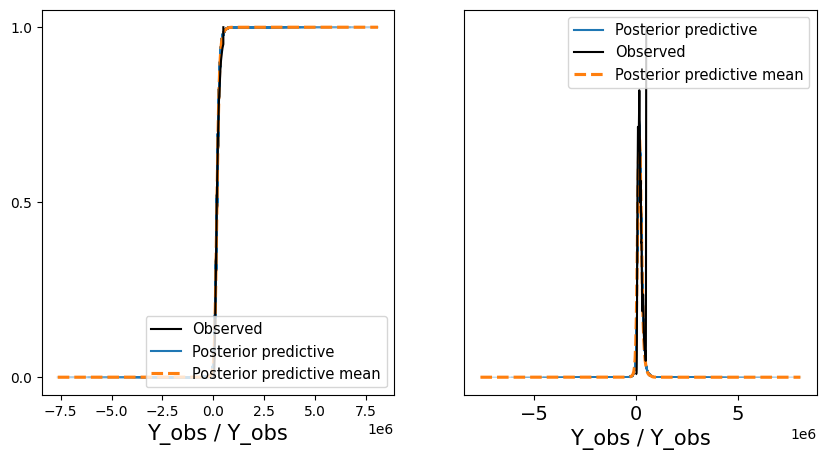

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_post_t, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(trace_post_t, group='posterior', ax=axes[1])

Para realizar a comparação e seleção do modelo mais adequado, devemos calcular o logaritmo da verossimilhança (log likelihood) para cada um. Essa métrica será crucial para avaliar o ajuste dos três modelos em questão: o modelo de regressão linear múltipla sem a população (multi_linreg, trace), o modelo com a variável população incluída (multi_linreg_pop, trace_pop), e o modelo robusto que também incorpora a população (multi_linreg_pop_t, trace_pop_t).

In [18]:
with multi_linreg_pop:
    pm.compute_log_likelihood(trace_pop)

with multi_linreg:
    pm.compute_log_likelihood(trace)

with multi_linreg_pop_t:
    pm.compute_log_likelihood(trace_p)

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

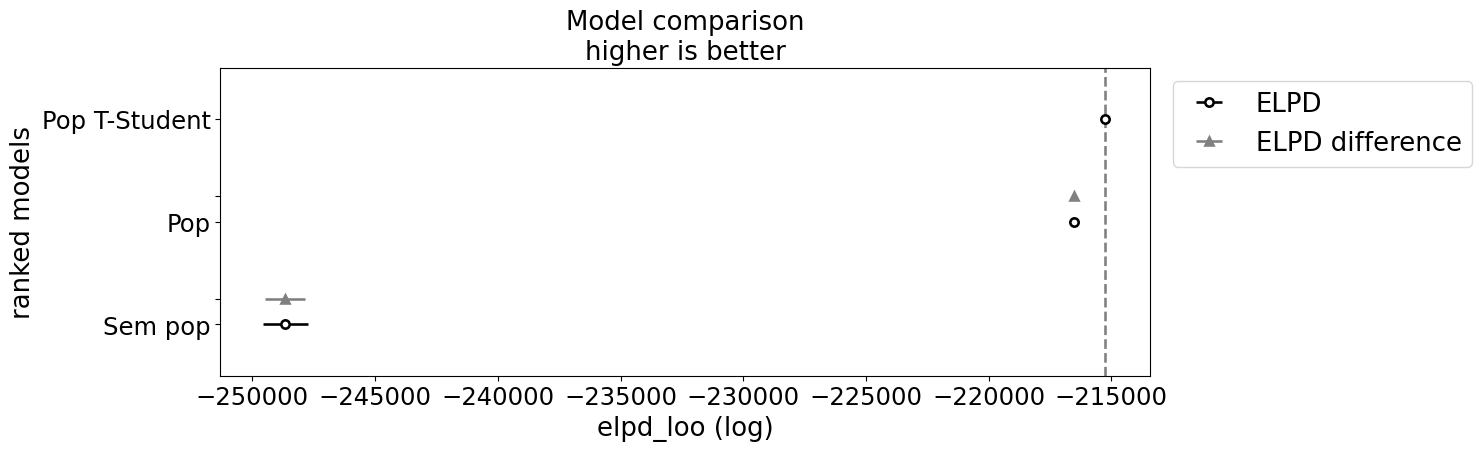

In [19]:
model_compare = az.compare(
    {
        "Pop T-Student": trace_p,
        "Pop": trace_pop,
        "Sem pop": trace,
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

In [20]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Pop T-Student,0,-215261.763176,6.489419,0.000000,1.0,126.821592,0.000000,False,log
Pop,1,-216529.414355,8.622828,1267.651180,0.0,177.648800,84.862533,False,log
Sem pop,2,-248669.912002,36.287881,33408.148827,0.0,918.112542,820.116378,False,log


O modelo escolhido será o robusto e com população. Agora vamos trabalhar para gerar dados preditivos a partir do modelo vencedor de acordo com o crtério ELPD LOO.

Vamos ler o arquivo de testes.

In [12]:
df_test = pd.read_csv('sample_data/california_housing_test.csv')

In [13]:
population_test = df_test['population'].values
median_income_test = df_test['median_income'].values
housing_median_age_test = df_test['housing_median_age'].values
median_house_value_test = df_test['median_house_value'].values


O conceito de MutableData em contextos de modelagem estatística, como implementado em bibliotecas como PyMC, permite a definição de variáveis cujos valores podem ser substituídos ou atualizados após a etapa de treinamento do modelo. Com essa funcionalidade, é possível primeiro treinar o modelo utilizando um conjunto de dados de treinamento e, posteriormente, fazer previsões aplicando o conjunto de dados de teste, sem a necessidade de recompilar o modelo. Isso proporciona uma flexibilidade significativa, permitindo a fácil alternância entre diferentes conjuntos de dados e a eficiente avaliação do desempenho do modelo em diferentes amostras. Em suma, conseguimos treinar o modelo e aprender seus parâmetros usando o conjunto de treinamento e gerar as predições de acordo com o arquivo de teste.

In [18]:
with pm.Model() as multi_linreg_pop_mutable:
    p_m = pm.MutableData('p_m', population)
    m_m = pm.MutableData('m_m', median_income)
    h_m = pm.MutableData('h_m', housing_median_age)
    y = pm.MutableData('y_m', median_house_value)
    alpha = pm.Normal('alpha', 0, 100000)
    beta_income = pm.Normal('beta_income', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    beta_pop = pm.Normal('beta_pop', 0, 5)
    sigma = pm.HalfNormal('sigma', 10000)

    mu = alpha + beta_income * m_m + beta_age * h_m + beta_pop * p_m
    df = pm.Exponential("df",1)
    Y_obs = pm.StudentT('Y_obs', nu=df, mu=mu, sigma=sigma, observed=y)

In [19]:
with multi_linreg_pop_mutable:
  trace_p_mutable = pm.sample()

In [21]:
with multi_linreg_pop_mutable:

    pm.set_data({
        "p_m": population_test,
        "m_m": median_income_test,
        "h_m": housing_median_age_test,
        "y_m":median_house_value_test})

In [22]:
with multi_linreg_pop_mutable:
    ppc = pm.sample_posterior_predictive(trace_p_mutable)

In [23]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

median_house_value_test = df_test['median_house_value'].values

median_house_predictive = ppc.posterior_predictive["Y_obs"].mean(["chain","draw"]).to_numpy()

mae = mean_absolute_error(median_house_value_test, median_house_predictive)
rmse = mean_squared_error(median_house_value_test, median_house_predictive, squared=False)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 58737.58994351528
RMSE: 82229.1206651057


Para avaliar a acurácia das previsões (median_house_predictive) do nosso modelo em comparação com os dados de teste, calculamos duas métricas de erro comum: o Erro Médio Absoluto (MAE) e a Raiz do Erro Quadrático Médio (RMSE). Esses cálculos nos ajudam a compreender a magnitude dos erros nas previsões.